<a href="https://colab.research.google.com/github/abdelrhmanhesham1/projects/blob/main/housing%20prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as SkLinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import plotly.express as px
import plotly.graph_objects as go

# Load data
df = pd.read_csv('/content/Housing.csv')
print("Initial Data Info:")
df.info()
print("\nInitial Head:\n", df.head())
print("\nInitial Description:\n", df.describe())


Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB

Initial Head:
       price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2  

In [5]:

# Data Cleaning
print("\nMissing Values:\n", df.isnull().sum())
df = df.drop_duplicates()
print(f"Rows after duplicates removal: {len(df)}")

# One-hot encoding with explicit handling
categorical_features = ['mainroad', 'guestroom', 'basement', 'hotwaterheating',
                        'airconditioning', 'prefarea', 'furnishingstatus']
df = pd.get_dummies(df, columns=categorical_features, drop_first=True, dtype=int)

# Feature Engineering
df['log_price'] = np.log1p(df['price'])  # Stabilize variance
df['log_area'] = np.log1p(df['area'])
df['area_per_bedroom'] = df['area'] / (df['bedrooms'] + 1e-6)  # Avoid division by zero
df['total_amenities'] = df[['bathrooms', 'stories', 'parking']].sum(axis=1)
df['interaction_area_bath'] = df['area'] * df['bathrooms']

# Outlier Removal
def remove_outliers(df, column, factor=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = max(df[column].min(), Q1 - factor * IQR)  # Respect min value
    upper_bound = min(df[column].max(), Q3 + factor * IQR)  # Respect max value
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for col in ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']:
    df = remove_outliers(df, col)
print(f"Rows after outlier removal: {len(df)}")

# Summary Stats
print("\nCleaned Summary Statistics:\n", df.describe())



Missing Values:
 price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64
Rows after duplicates removal: 545
Rows after outlier removal: 365

Cleaned Summary Statistics:
               price          area    bedrooms  bathrooms     stories  \
count  3.650000e+02    365.000000  365.000000      365.0  365.000000   
mean   4.045012e+06   4623.810959    2.742466        1.0    1.553425   
std    1.247181e+06   1723.729307    0.624130        0.0    0.616192   
min    1.750000e+06   1650.000000    1.000000        1.0    1.000000   
25%    3.150000e+06   3460.000000    2.000000        1.0    1.000000   
50%    3.850000e+06   4079.000000    3.000000        1.0    1.000000   
75%    4.690000e+06   5800.000000    3.000000        1.0    2.000000   
max    9.1

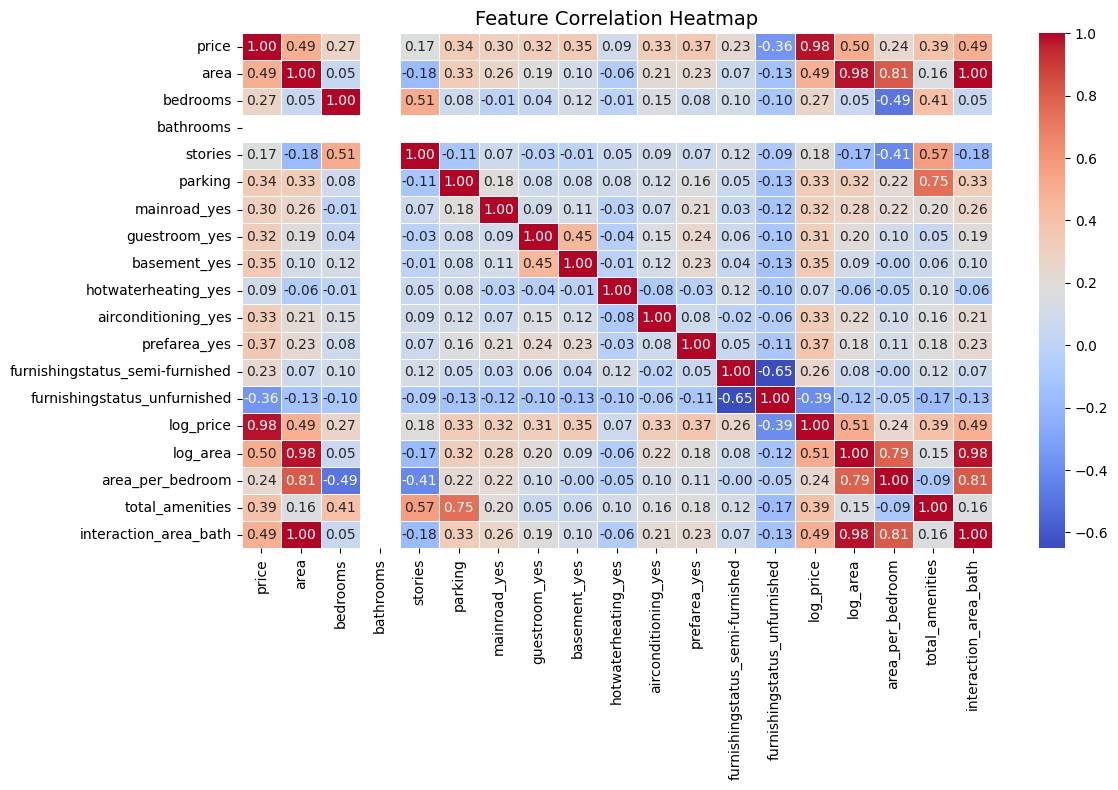

In [6]:

# Correlation Analysis
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.tight_layout()
plt.show()




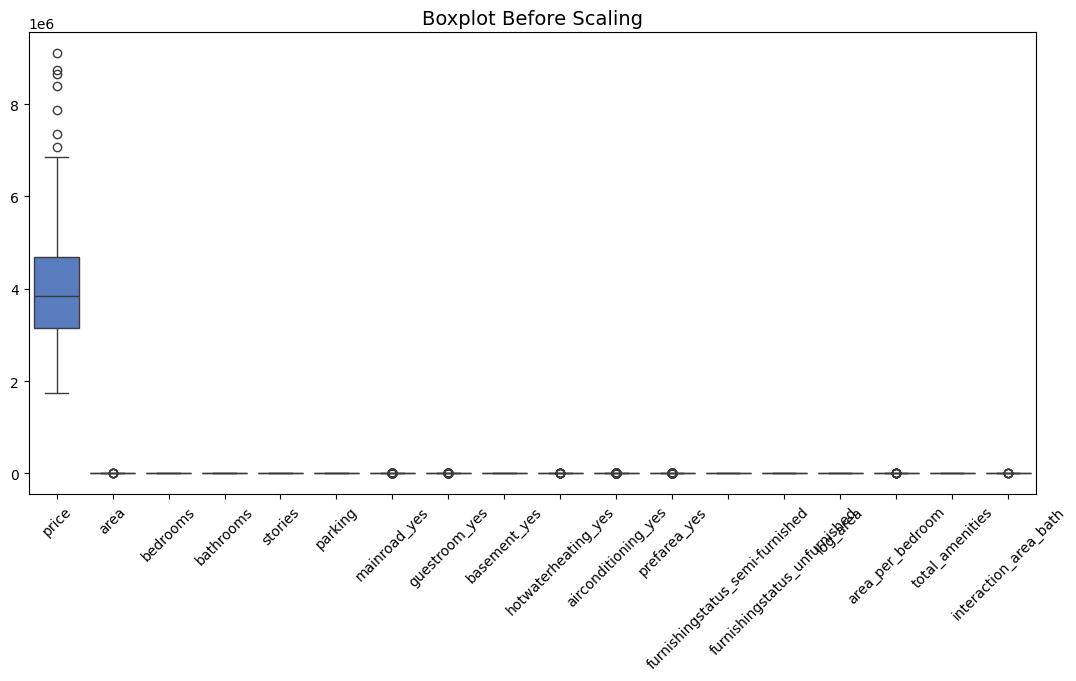

In [7]:
# Boxplot Before Scaling
plt.figure(figsize=(13, 6))
sns.boxplot(data=df.drop(columns=['log_price']), palette="muted")
plt.title('Boxplot Before Scaling', fontsize=14)
plt.xticks(rotation=45)
plt.show()


<ipython-input-8-91531d814e06>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Rows after post-scaling outlier removal: 140


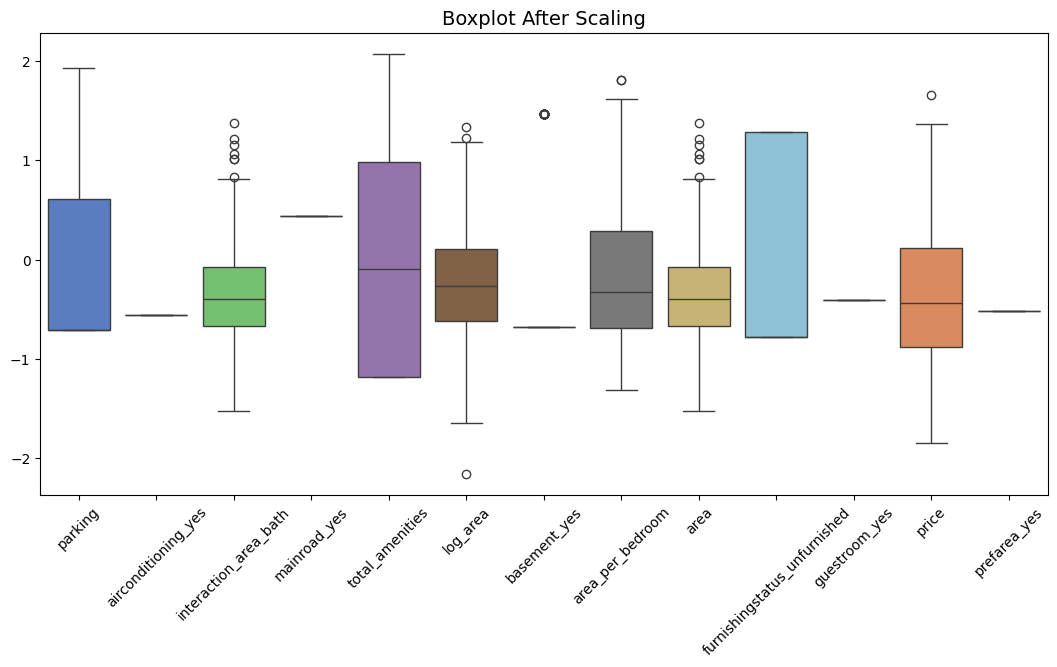

In [8]:

# Feature Selection
corr_threshold = 0.3
selected_features = df.corr()['price'][abs(df.corr()['price']) > corr_threshold].index.tolist()
engineered_features = ['log_price', 'log_area', 'area_per_bedroom', 'total_amenities', 'interaction_area_bath']
selected_features = list(set(selected_features + engineered_features))
df_selected = df[selected_features]

# Scaling
scaler = StandardScaler()
numerical_features = df_selected.columns.drop('log_price')
df_selected[numerical_features] = scaler.fit_transform(df_selected[numerical_features])
# Post-Scaling Outlier Removal
for col in numerical_features:
    Q1 = df_selected[col].quantile(0.25)
    Q3 = df_selected[col].quantile(0.75)
    IQR = Q3 - Q1
    df_selected = df_selected[(df_selected[col] >= Q1 - 1.5 * IQR) &
                              (df_selected[col] <= Q3 + 1.5 * IQR)]
print(f"Rows after post-scaling outlier removal: {len(df_selected)}")
# Boxplot After Scaling
plt.figure(figsize=(13, 6))
sns.boxplot(data=df_selected.drop(columns=['log_price']), palette="muted")
plt.title('Boxplot After Scaling', fontsize=14)
plt.xticks(rotation=45)
plt.show()


In [9]:
# Train-Test Split
X = df_selected.drop('log_price', axis=1)
y = df_selected['log_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Custom Linear Regression
class LinearRegression:
    def __init__(self):
        self.coefficients = None

    def fit(self, X, y):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        reg = 1e-6 * np.eye(X_b.shape[1])
        self.coefficients = np.linalg.inv(X_b.T.dot(X_b) + reg).dot(X_b.T).dot(y)

    def predict(self, X):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        return X_b.dot(self.coefficients)

    def evaluate(self, y_true, y_pred, name="Custom Linear Regression"):
        y_true_orig = np.expm1(y_true)
        y_pred_orig = np.expm1(y_pred)
        mse = mean_squared_error(y_true_orig, y_pred_orig)
        mae = mean_absolute_error(y_true_orig, y_pred_orig)
        r2 = r2_score(y_true, y_pred)
        print(f"\n{name} Results:")
        print(f"MSE: {mse:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"R²: {r2:.4f}")
        return mse, mae, r2


In [10]:

# Train and evaluate models
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
lr_mse, lr_mae, lr_r2 = lr.evaluate(y_test, y_pred)

# Scikit-Learn Linear Regression
sk_lr = SkLinearRegression()
sk_lr.fit(X_train, y_train)
y_pred_sk = sk_lr.predict(X_test)
sk_mse, sk_mae, sk_r2 = lr.evaluate(y_test, y_pred_sk, "Scikit-Learn Linear Regression")

# Polynomial Regression with Ridge
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)
poly_lr = Ridge(alpha=1.0, solver='cholesky')
poly_lr.fit(X_train_poly, y_train)
y_pred_poly = poly_lr.predict(X_test_poly)
poly_mse, poly_mae, poly_r2 = lr.evaluate(y_test, y_pred_poly, "Polynomial Regression (Degree 2, Ridge)")



Custom Linear Regression Results:
MSE: 11485448845.08
MAE: 78585.98
R²: 0.9752

Scikit-Learn Linear Regression Results:
MSE: 11485452128.28
MAE: 78586.00
R²: 0.9752

Polynomial Regression (Degree 2, Ridge) Results:
MSE: 1564157706.44
MAE: 27984.68
R²: 0.9974


In [11]:

# Visualizations
df_results = pd.DataFrame({
    'Actual': np.expm1(y_test),
    'Custom Linear': np.expm1(y_pred),
    'Scikit-Learn Linear': np.expm1(y_pred_sk),
    'Polynomial': np.expm1(y_pred_poly)
}).melt(id_vars=['Actual'], var_name='Model', value_name='Predicted')

fig = px.scatter(df_results, x='Actual', y='Predicted', color='Model',
                 title="Actual vs Predicted Prices (Housing Dataset)",
                 labels={'Actual': 'Actual Price', 'Predicted': 'Predicted Price'},
                 template='plotly_white')
fig.add_trace(go.Scatter(
    x=[df_results['Actual'].min(), df_results['Actual'].max()],
    y=[df_results['Actual'].min(), df_results['Actual'].max()],
    mode='lines', name='Ideal Prediction', line=dict(dash='dash', color='black')
))
fig.update_layout(showlegend=True, font=dict(size=12))
fig.show()


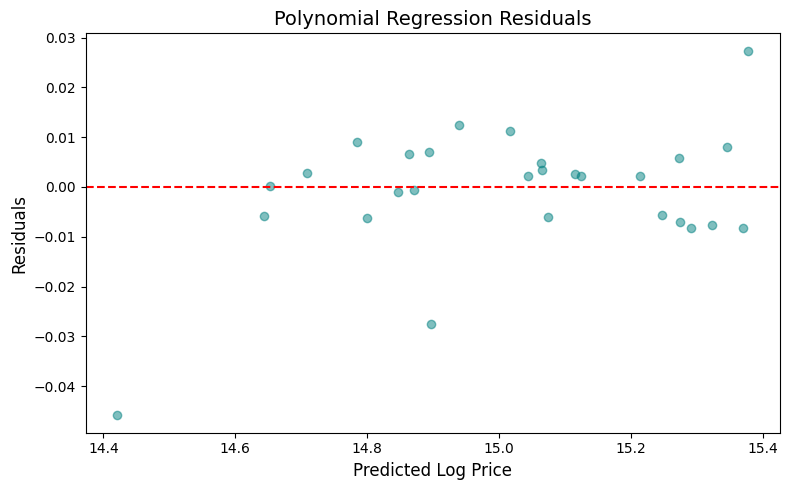

In [12]:

# Residual Plot for Polynomial Model
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_poly, y_test - y_pred_poly, alpha=0.5, color='teal')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Log Price", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.title("Polynomial Regression Residuals", fontsize=14)
plt.tight_layout()
plt.show()